# Support Vector Machine

In [1]:
from sklearn.svm import SVR, SVC
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_recall_fscore_support
)
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
problem_types = ['regression','classification'] #regression or classification
input_types = ["genetic_algorithm","random_forest_elimination","correlation_variance_filter","PCA","Factor_Analysis"] #reduced features: , genetic_algorithm, PCA, Factor_Analysis, random_forest
seed = 254

In [3]:
def read_file(problem_type, input_file):
    """
    Read input features and recover target values (IC50 or Potency).

    Parameters:
        problem_type (str): 'regression' or 'classification'.
        input_file (str): Path to the input feature file.

    Returns:
        tuple:
            - X_indexed (pd.DataFrame): Feature DataFrame indexed by 'Molecule ChEMBL ID'.
            - target (pd.Series): Target values indexed by 'Molecule ChEMBL ID'.
    """
    # Validate problem type
    if problem_type not in {'regression', 'classification'}:
        raise ValueError("Invalid problem_type. Must be 'regression' or 'classification'.")

    # Define the target column based on problem type
    target_column = '-logIC50' if problem_type == 'regression' else 'Potency'

    # Load input features and target data
    X = pd.read_csv(input_file)
    target = pd.read_csv('../../3_train_test_split/descriptors_all.csv', usecols=['Molecule ChEMBL ID', target_column])

    # Merge target data with features based on 'Molecule ChEMBL ID'
    target = target[target['Molecule ChEMBL ID'].isin(X['Molecule ChEMBL ID'])]

    # Return original and indexed feature DataFrame, and target values as a Series
    return X.set_index('Molecule ChEMBL ID'), target.set_index('Molecule ChEMBL ID')[target_column]

In [4]:
def run_svm(problem_type, input_type, seed):
    """
    Run Support Vector Machine (SVM) for regression or classification with 5-fold cross-validation and hyperparameter optimization.

    Parameters:
        problem_type (str): 'regression' or 'classification'.
        input_type (str): Feature reduction scheme directory (e.g., 'PCA', 'Factor_Analysis').
        seed (int): Random seed for reproducibility.

    Returns:
        dict: Best model, test predictions, evaluation metrics, and test dataset.
    """
    base_dir = f"../../4_feature_selection/{input_type}/"
    if input_type == "genetic_algorithm":
        base_dir = os.path.join(base_dir, "SVM/")
    elif input_type == "PCA":
        base_dir = os.path.join(base_dir, "PCA_results/PCA_components")
    elif input_type == "Factor_Analysis":
        base_dir = os.path.join(base_dir, "FA_results/selected_features")

    # Determine problem-specific file prefixes
    problem = "reg" if problem_type == "regression" else "class"
    test_file = os.path.join(base_dir, f"test_{problem}.csv")

    # Load test dataset
    X_test, y_test = read_file(problem_type, test_file)

    # Initialize SVM model and hyperparameter grid
    if problem_type == "regression":
        model = SVR()
        scoring = make_scorer(mean_squared_error, greater_is_better=False)
        param_distributions = {
            'C': [0.1, 1, 10, 100],
            'epsilon': [0.1, 0.2, 0.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    elif problem_type == "classification":
        model = SVC(probability=True, class_weight="balanced", random_state=seed)
        scoring = "accuracy"
        param_distributions = {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    else:
        raise ValueError("Invalid problem_type. Choose 'regression' or 'classification'.")

    # Perform 5-fold cross-validation
    print(f"Running 5-fold cross-validation for SVM ({problem_type})...")
    fold_metrics = []
    best_models = []

    for fold in range(1, 6):
        train_file = os.path.join(base_dir, f"train_{problem}_{fold}.csv")
        val_file = os.path.join(base_dir, f"val_{problem}_{fold}.csv")

        # Load training and validation data
        X_train, y_train = read_file(problem_type, train_file)
        X_val, y_val = read_file(problem_type, val_file)

        # Hyperparameter tuning using RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=20,  # Number of random parameter combinations to try
            scoring=scoring,
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=seed,
        )
        random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        best_models.append(best_model)

        y_val_pred = best_model.predict(X_val)
        if problem_type == "regression":
            metric = mean_squared_error(y_val, y_val_pred)
        else:
            metric = accuracy_score(y_val, y_val_pred)

        fold_metrics.append(metric)
        print(f"Fold {fold} - Best Model Metric: {metric:.4f}")

    # Average metric across folds
    avg_metric = np.mean(fold_metrics)
    print(f"Average Cross-Validation Metric: {avg_metric:.4f}")

    # Evaluate the best model on the test set
    if problem_type == "regression":
        final_model = best_models[np.argmin(fold_metrics)]  # Best model with lowest MSE
        test_metric = mean_squared_error(y_test, final_model.predict(X_test))
        print(f"Test MSE: {test_metric:.4f}")
    else:
        final_model = best_models[np.argmax(fold_metrics)]  # Best model with highest accuracy
        test_metric = accuracy_score(y_test, final_model.predict(X_test))
        print(f"Test Accuracy: {test_metric:.4f}")

    # Evaluate the model on the test set and return results
    evaluate_model(final_model, X_test, y_test, problem_type, input_type, "SVM")

    return {
        'best_model': final_model,
        'test_predictions': final_model.predict(X_test),
        'test_metric': test_metric,
        'X_test': X_test,
        'y_test': y_test
    }

In [5]:
def evaluate_model(final_model, X_test, y_test, problem_type, input_type, model_type):
    """
    Evaluate the model, create plots, and save performance summary and predictions.

    Parameters:
        final_model: Trained model.
        X_test (pd.DataFrame): Test feature set.
        y_test (pd.Series): True target values for the test set.
        problem_type (str): 'regression' or 'classification'.
        input_type (str): Feature reduction scheme used.
        model_type (str): Model type (default is 'random forest').

    Returns:
        None
    """
    # Generate file prefix
    file_prefix = f"{model_type}_{problem_type}_{input_type}"

    # Predictions
    y_pred = final_model.predict(X_test)

    if problem_type == "regression":
        # Calculate regression metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        pearson_corr, _ = pearsonr(y_test, y_pred)

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "mse": mse,
            "r2_score": r2,
            "pearson_corr": pearson_corr
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True IC50": y_test,
            "Predicted IC50": y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        # Plot Predicted vs Target
        plt.figure(figsize=(6, 6), dpi=150)
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
        plt.xlabel("True IC50")
        plt.ylabel("Predicted IC50")
        plt.title("Predicted vs True")
        plt.savefig(f"{file_prefix}_predicted_vs_true.png")
        plt.show()

        # Plot Residuals
        residuals = y_test - y_pred
        plt.figure(figsize=(6, 6), dpi=150)
        sns.scatterplot(x=y_test, y=residuals, alpha=0.7)
        plt.axhline(0, color="red", linestyle="--")
        plt.xlabel("True IC50")
        plt.ylabel("Residuals")
        plt.title("Residual Plot")
        plt.savefig(f"{file_prefix}_residuals.png")
        plt.show()

    elif problem_type == "classification":
        # Calculate classification metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True Potency": y_test,
            "Predicted Potency": y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
        disp.plot(cmap="Blues", values_format="d")
        plt.title("Confusion Matrix")
        plt.savefig(f"{file_prefix}_confusion_matrix.png")
        plt.show()

        # Plot ROC Curve
        if hasattr(final_model, "predict_proba"):
            y_proba = final_model.predict_proba(X_test)
            plt.figure(figsize=(8, 6), dpi=150)
            for i, class_label in enumerate(final_model.classes_):
                fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], color="red", linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve (One-vs-Rest)")
            plt.legend()
            plt.savefig(f"{file_prefix}_roc_curve.png")
            plt.show()

## Train and Evaluate Model

Training SVM model for regression using genetic_algorithm features...
Running 5-fold cross-validation for SVM (regression)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 3.0964
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 3.4788
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 4.7914
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 5.4026
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 2.7164
Average Cross-Validation Metric: 3.8971
Test MSE: 3.5576


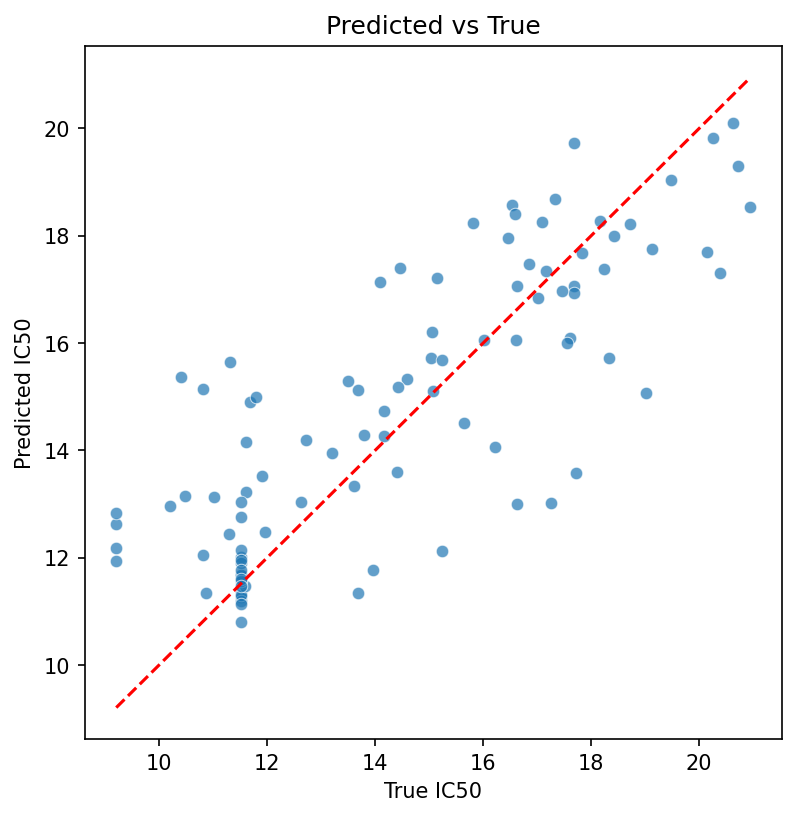

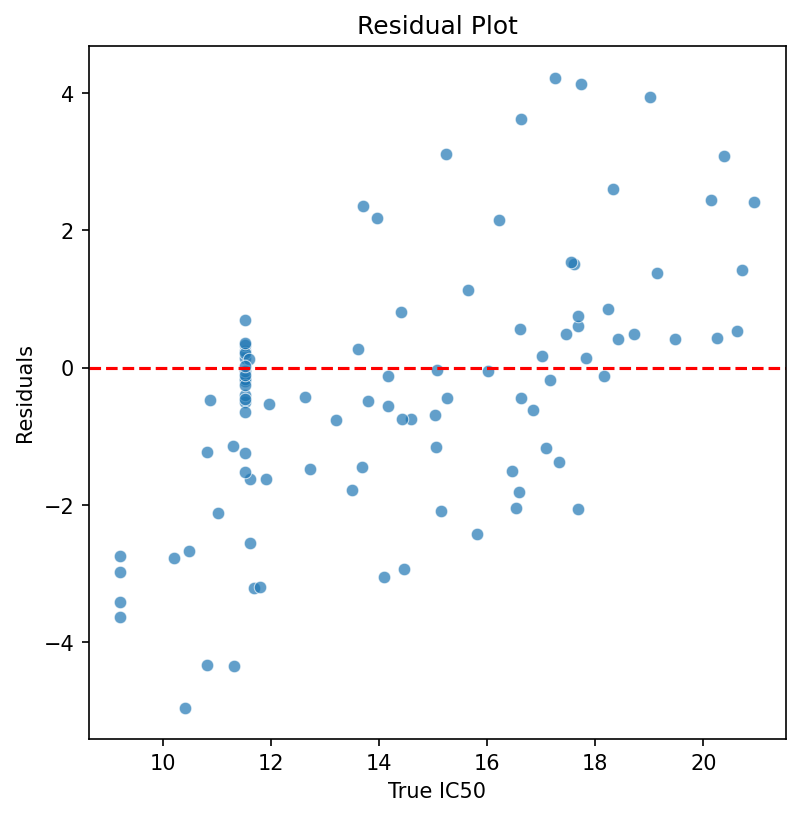

Evaluating the model...


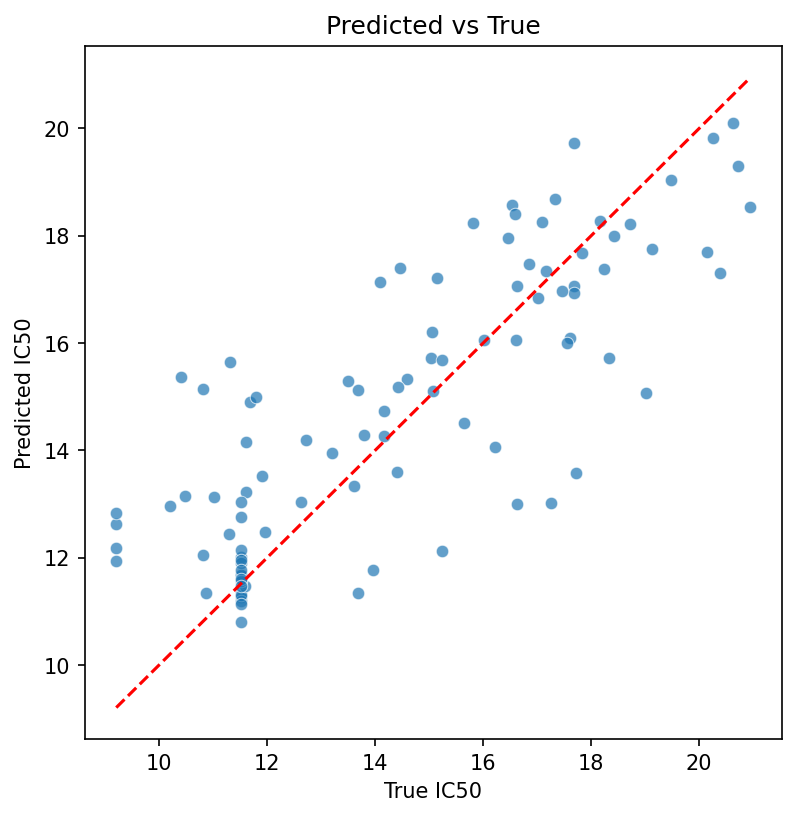

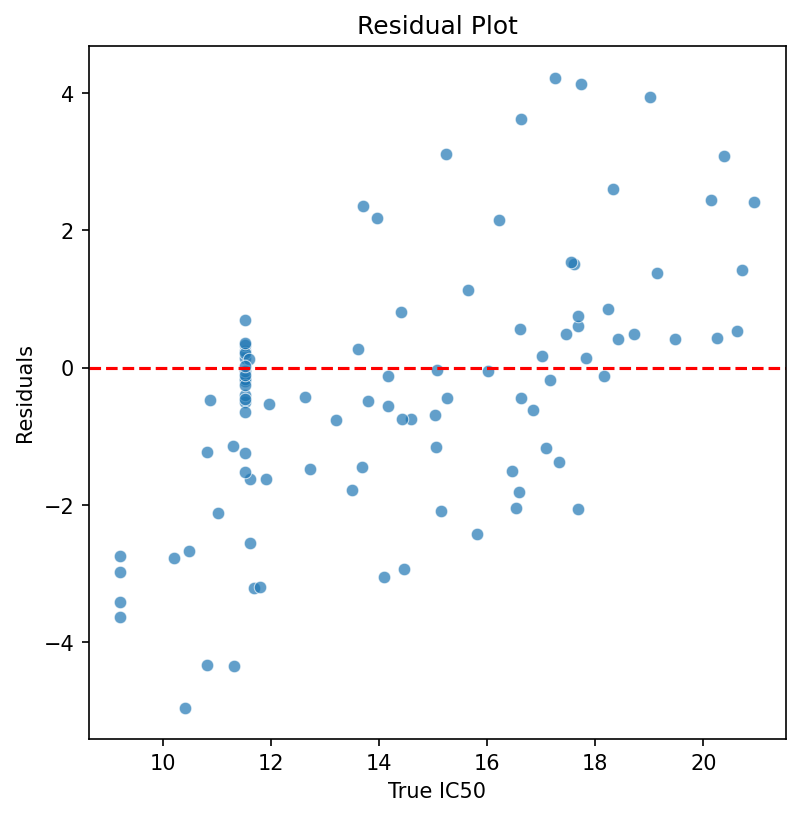

Training and evaluation complete
Training SVM model for regression using random_forest_elimination features...
Running 5-fold cross-validation for SVM (regression)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 9.1609
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 8.5186
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 9.0009
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 11.2682
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 8.2702
Average Cross-Validation Metric: 9.2438
Test MSE: 11.2990


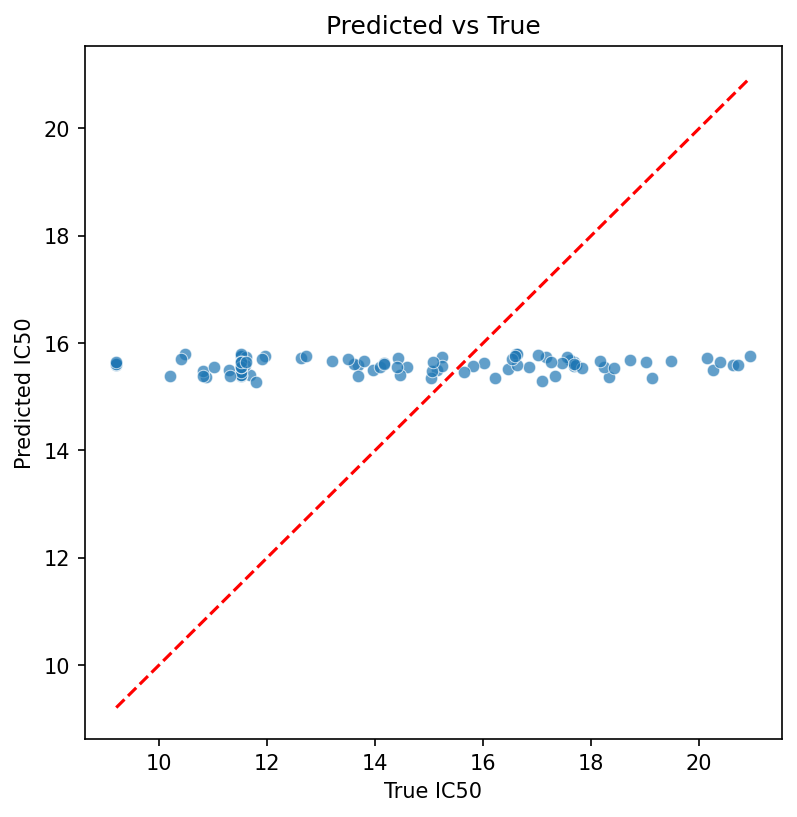

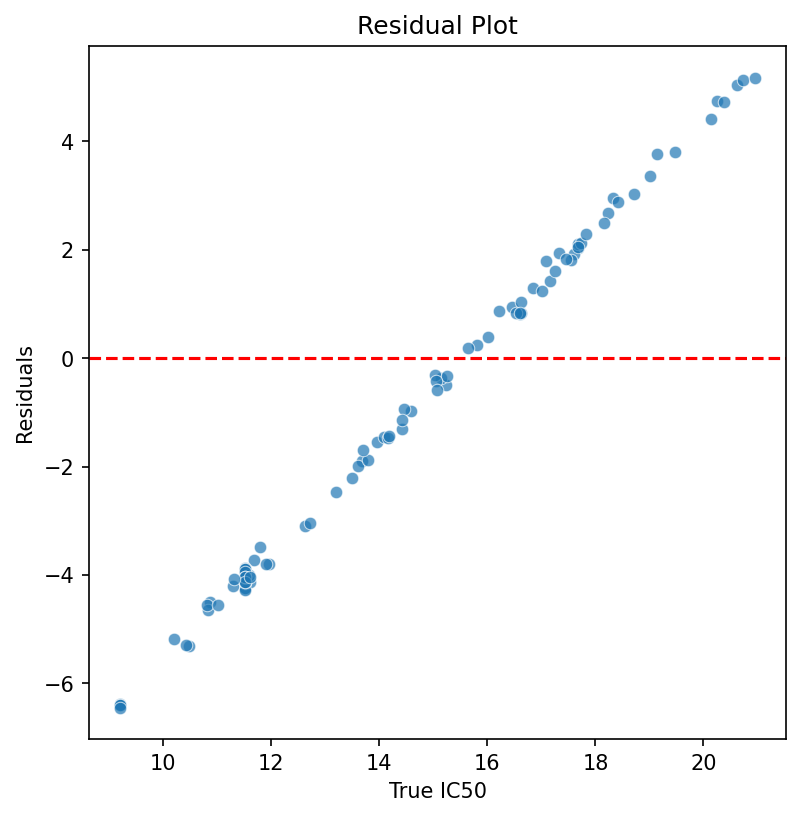

Evaluating the model...


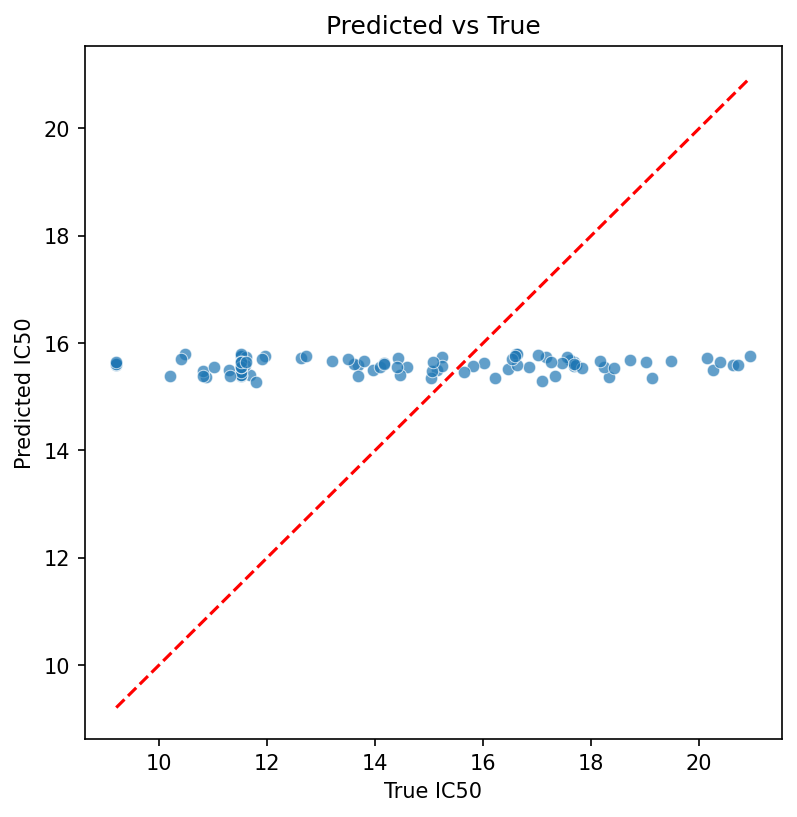

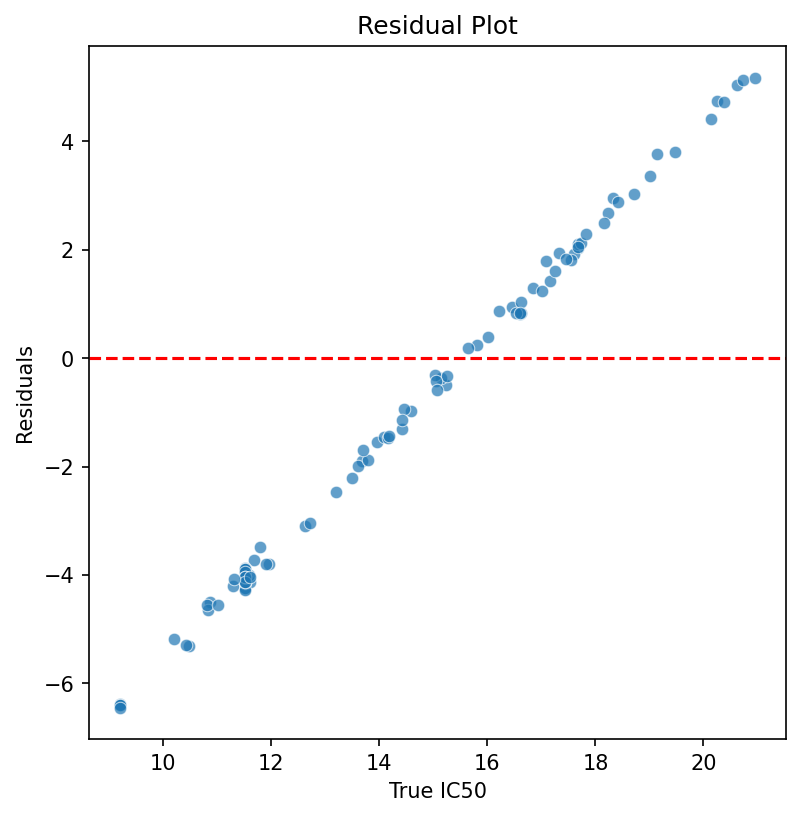

Training and evaluation complete
Training SVM model for regression using correlation_variance_filter features...
Running 5-fold cross-validation for SVM (regression)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 4.3269
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 4.7658
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 6.6162
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 6.9685
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 3.4305
Average Cross-Validation Metric: 5.2216
Test MSE: 5.1616


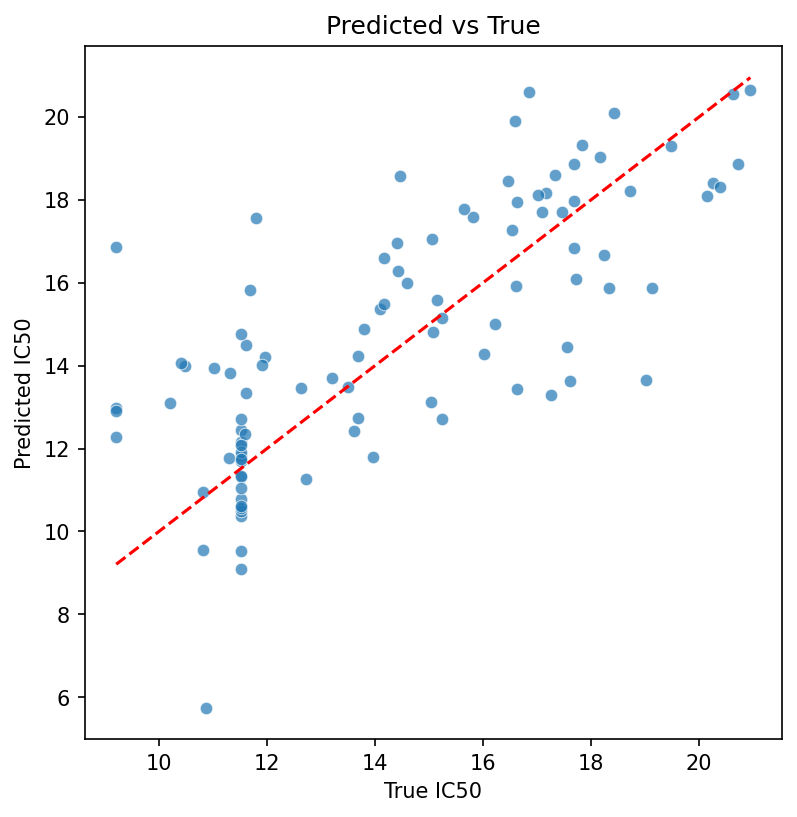

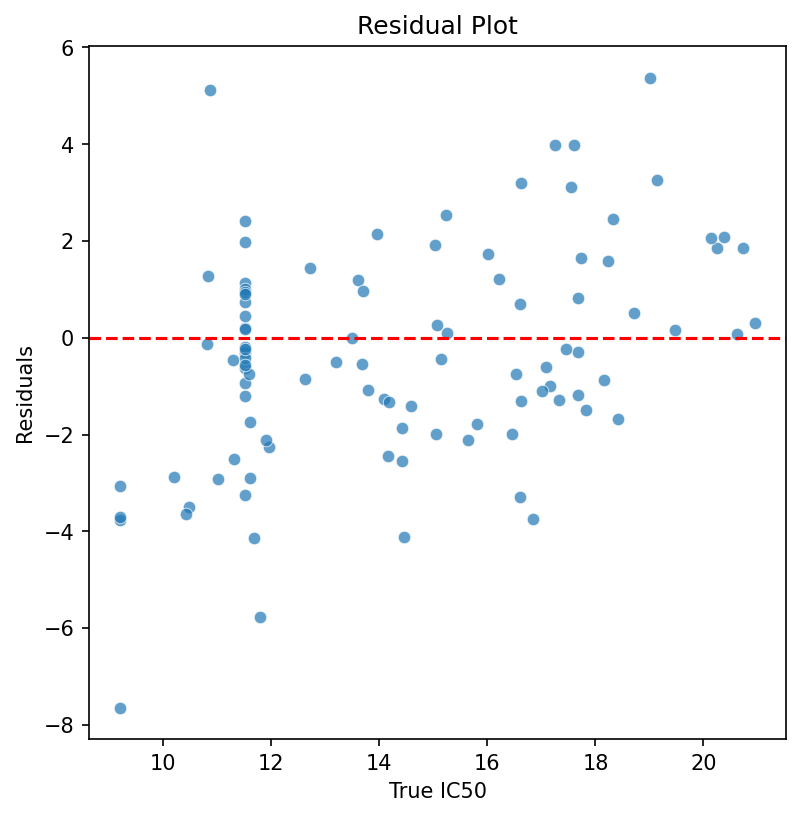

Evaluating the model...


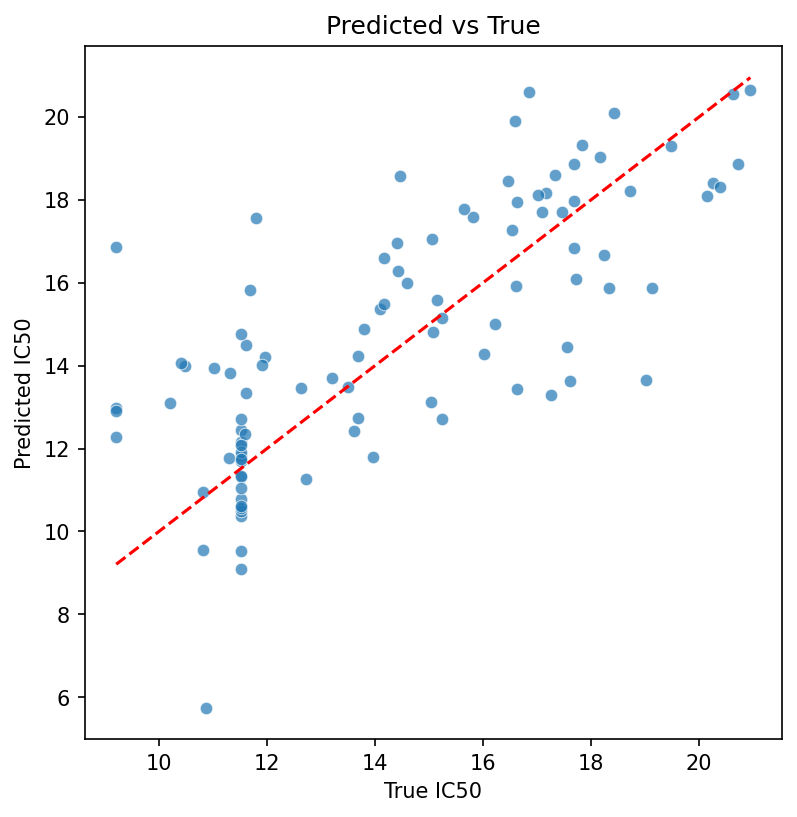

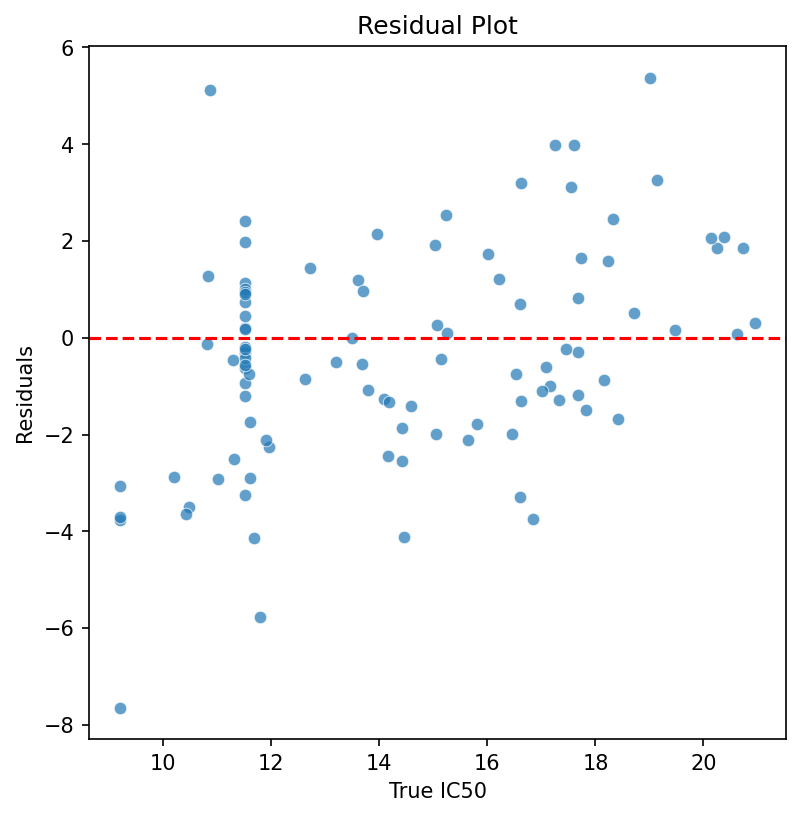

Training and evaluation complete
Training SVM model for regression using PCA features...
Running 5-fold cross-validation for SVM (regression)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 9.1637
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 8.6199
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 9.1082
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 11.2331
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 8.3447
Average Cross-Validation Metric: 9.2939
Test MSE: 10.5407


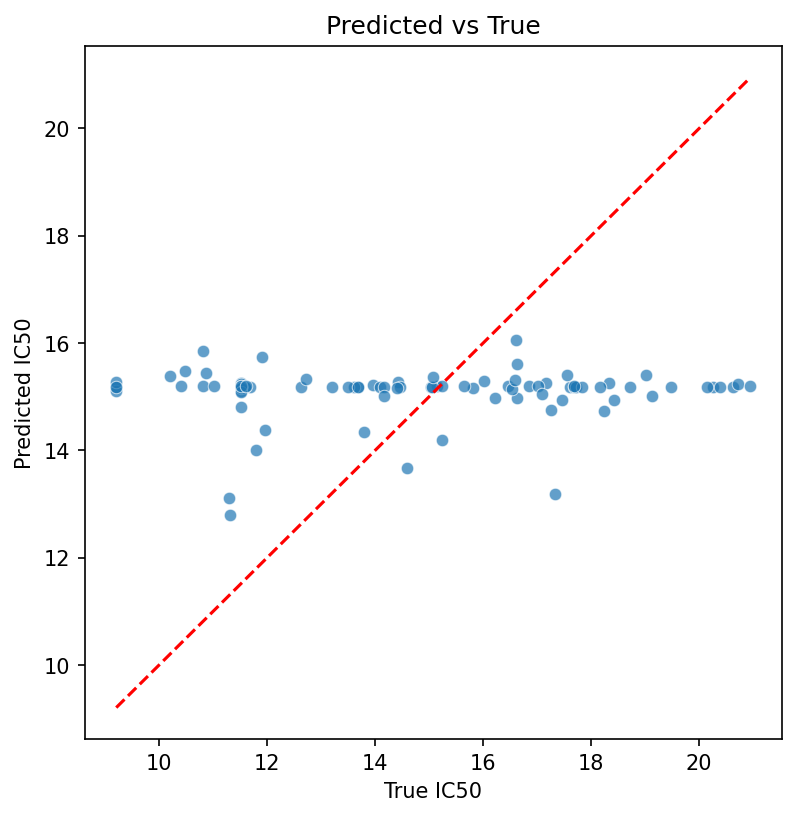

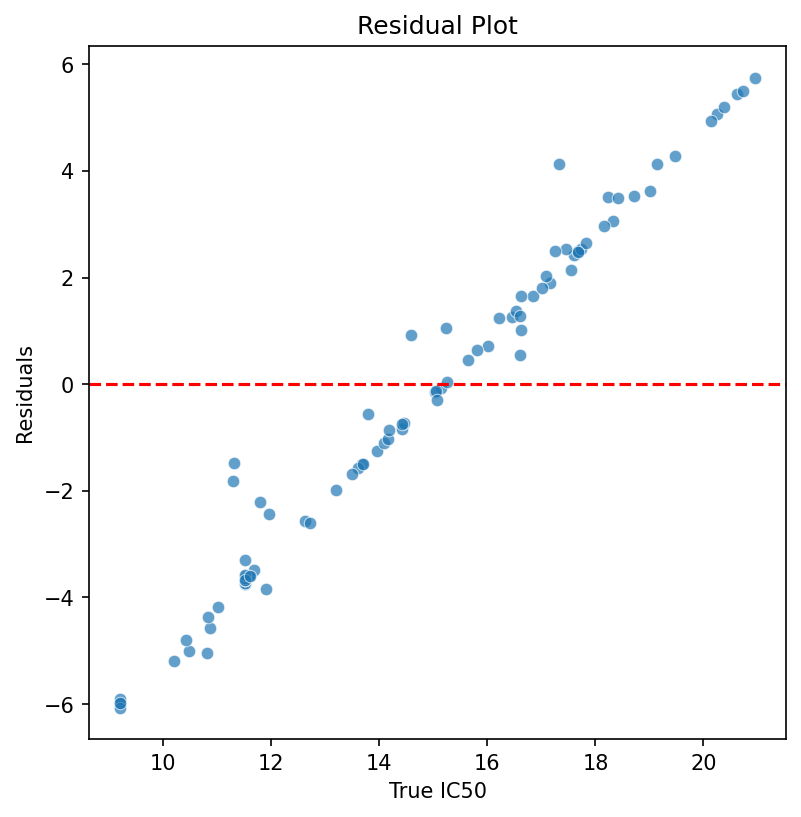

Evaluating the model...


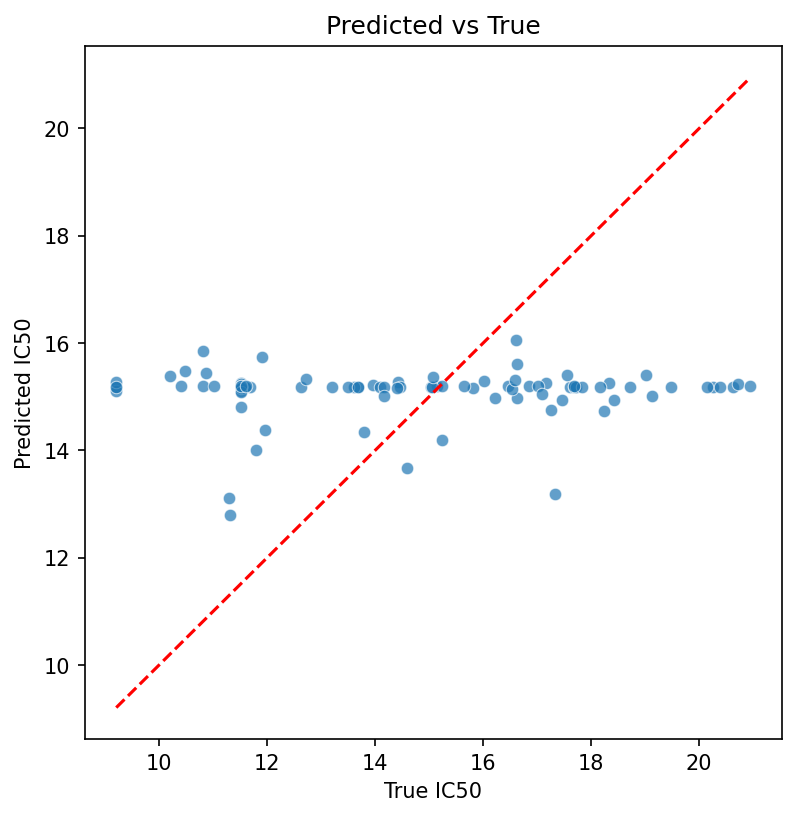

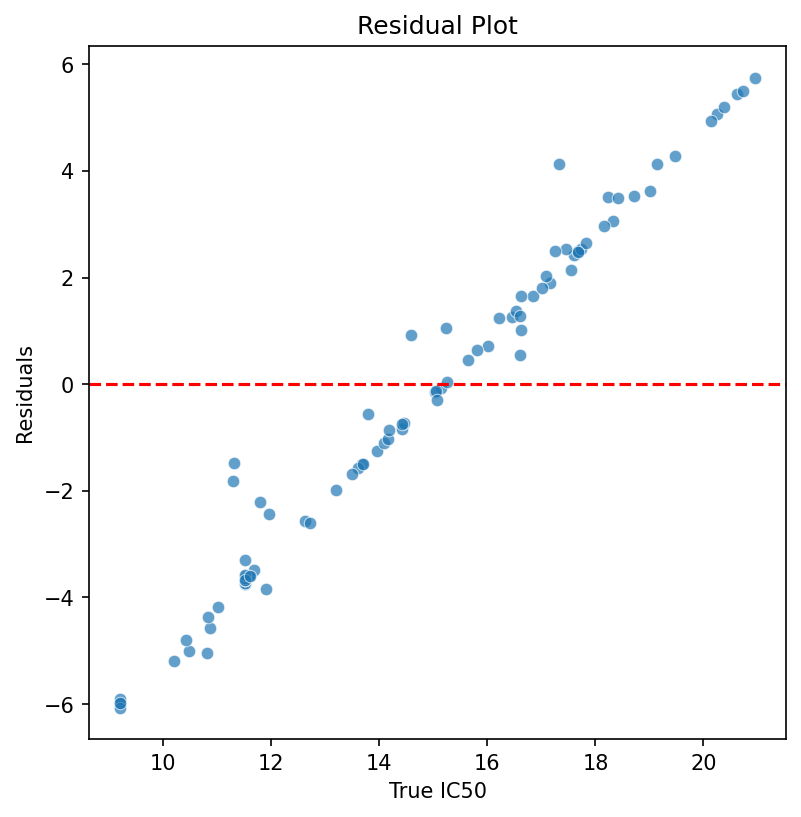

Training and evaluation complete
Training SVM model for regression using Factor_Analysis features...
Running 5-fold cross-validation for SVM (regression)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 9.1537
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 8.5336
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 9.0743
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 11.2783
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 8.2661
Average Cross-Validation Metric: 9.2612
Test MSE: 11.3694


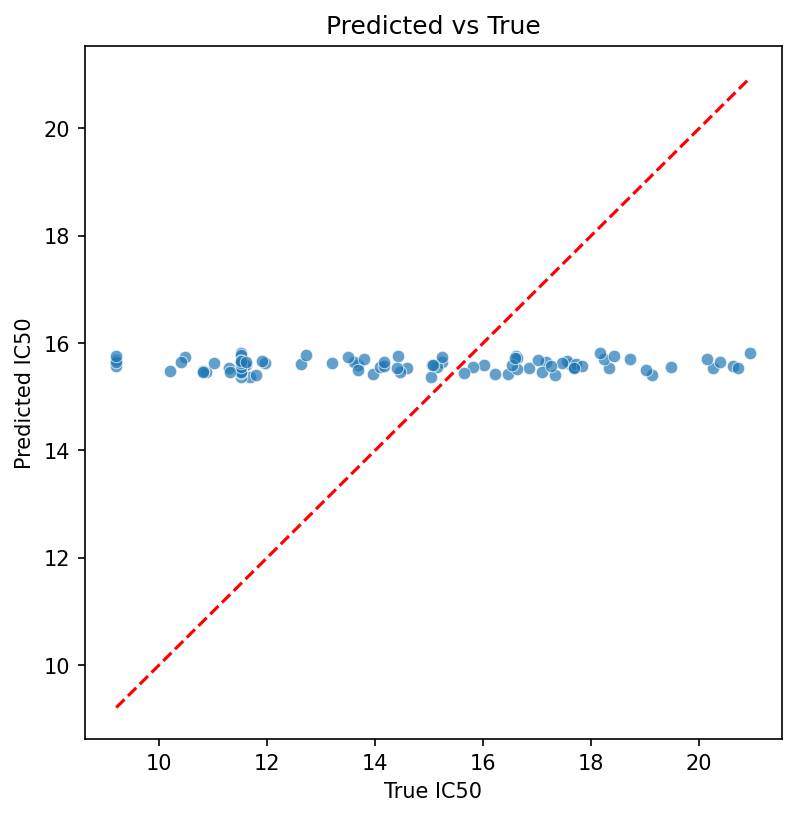

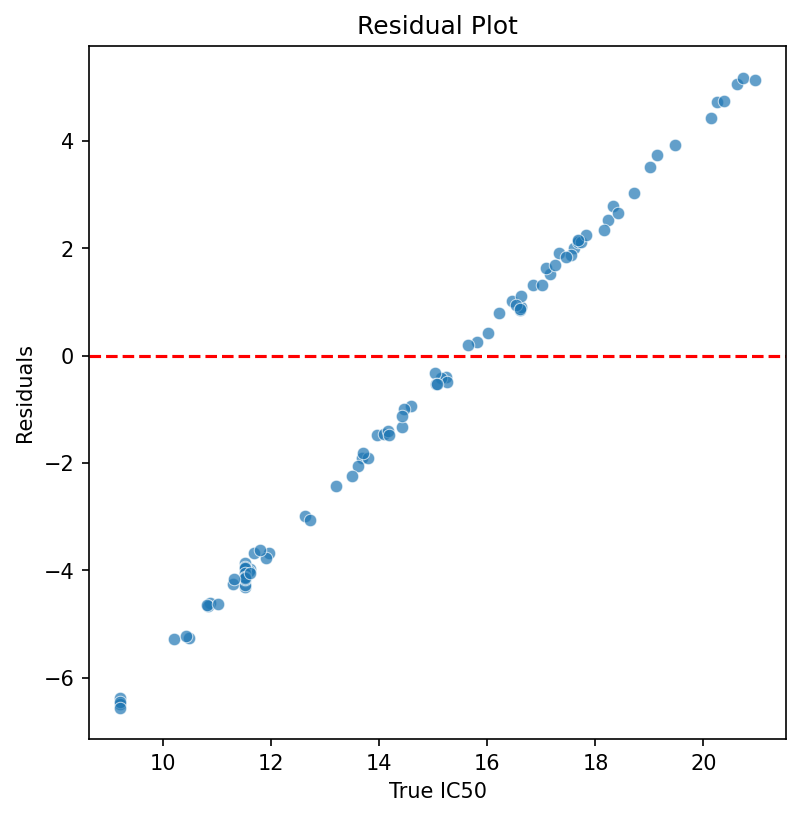

Evaluating the model...


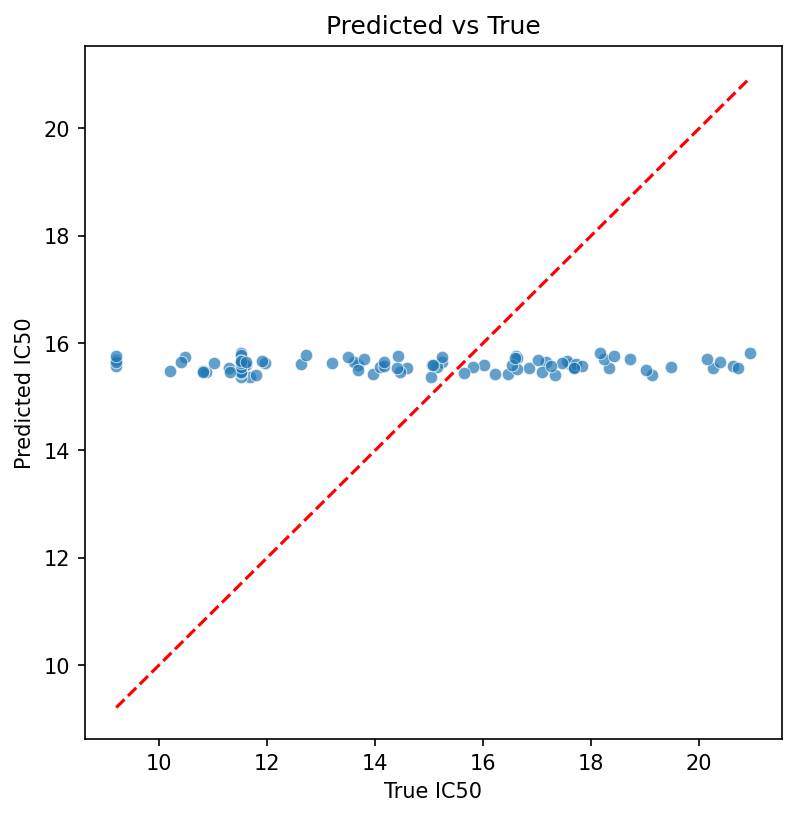

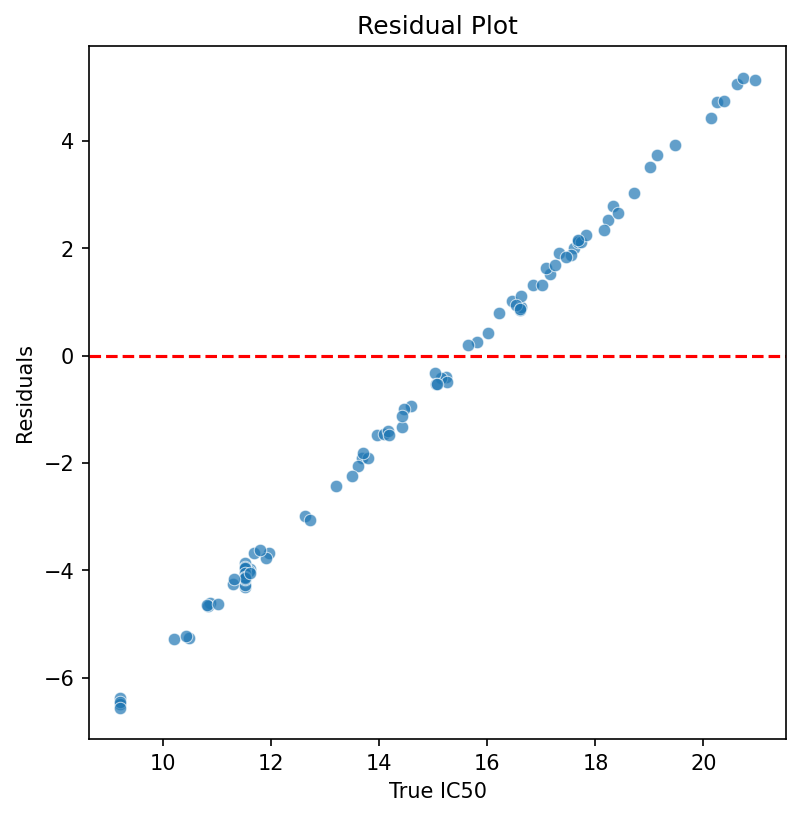

Training and evaluation complete
Training SVM model for classification using genetic_algorithm features...
Running 5-fold cross-validation for SVM (classification)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 0.5586
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 0.5586
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 0.6216
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 0.5315
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 0.4865
Average Cross-Validation Metric: 0.5514
Test Accuracy: 0.6364


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


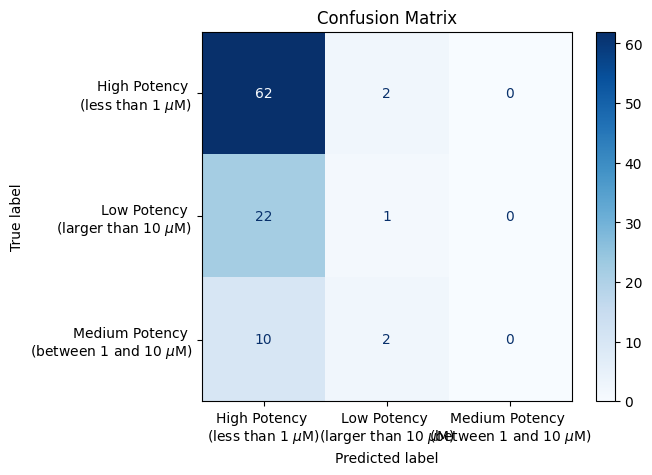

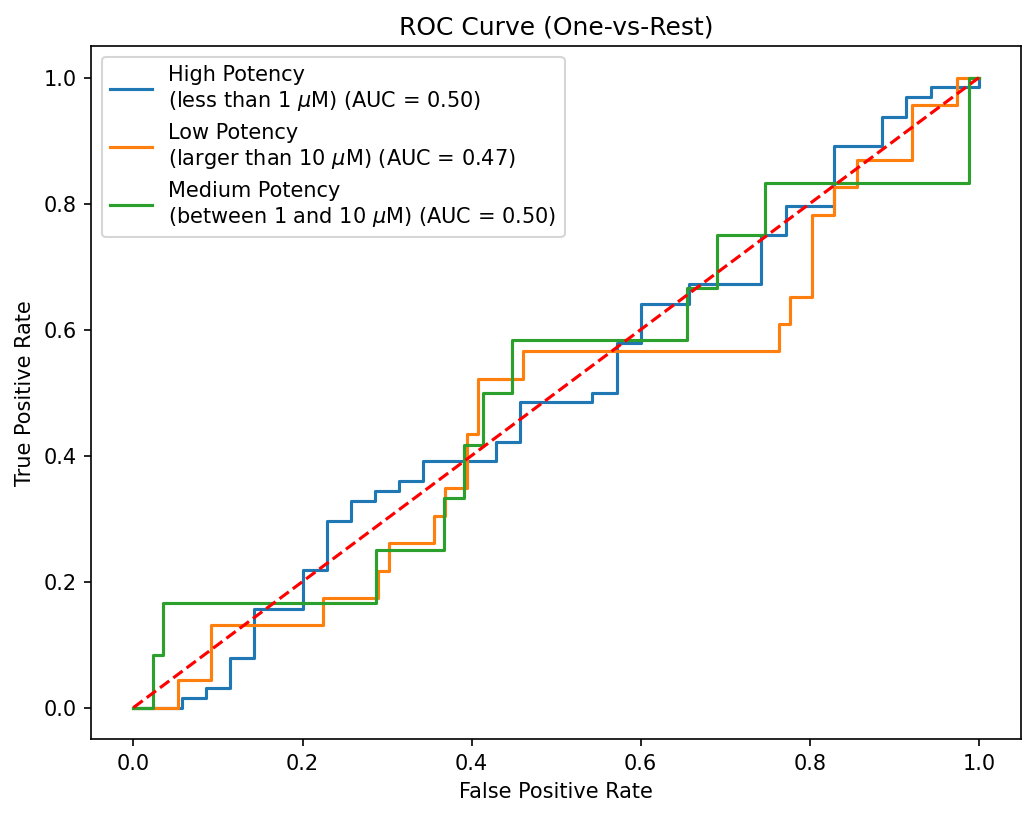

Evaluating the model...


/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


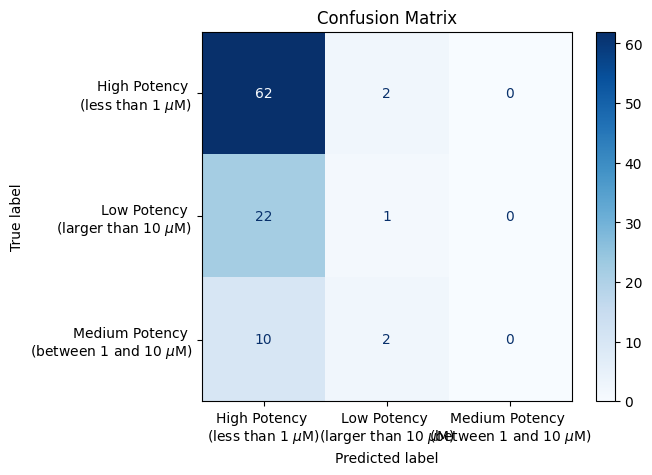

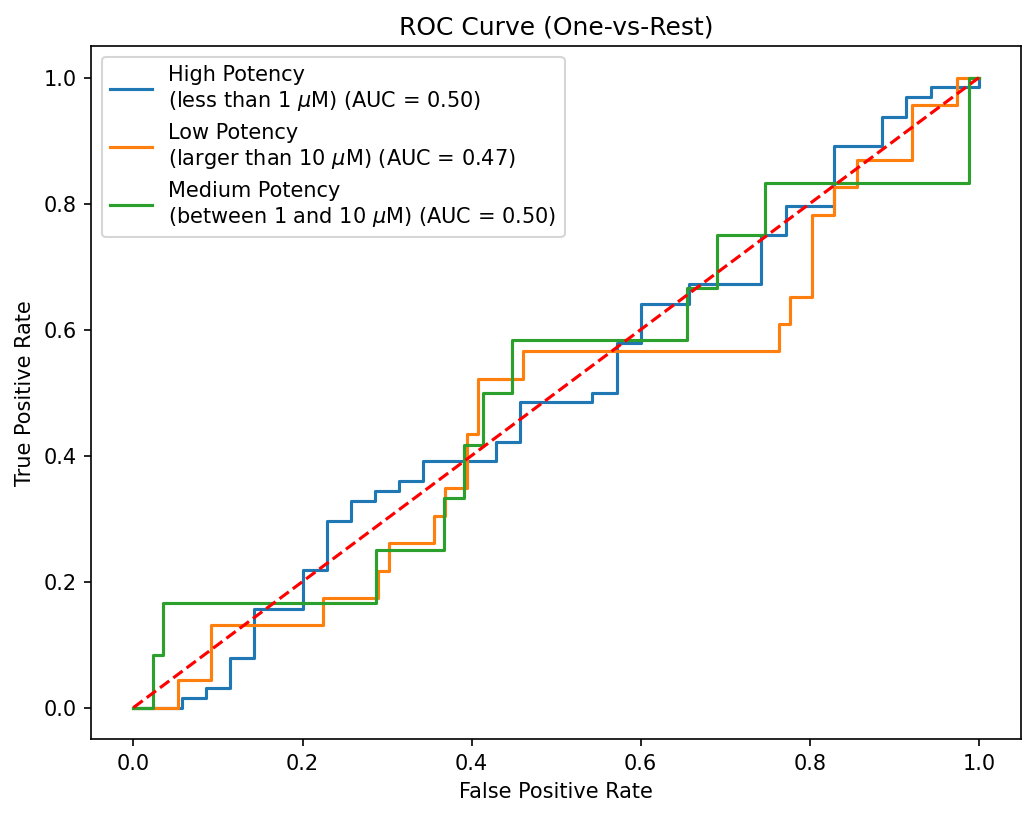

Training and evaluation complete
Training SVM model for classification using random_forest_elimination features...
Running 5-fold cross-validation for SVM (classification)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 0.4775
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 0.5225
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 0.5586
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 0.5135
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 0.5045
Average Cross-Validation Metric: 0.5153
Test Accuracy: 0.5354


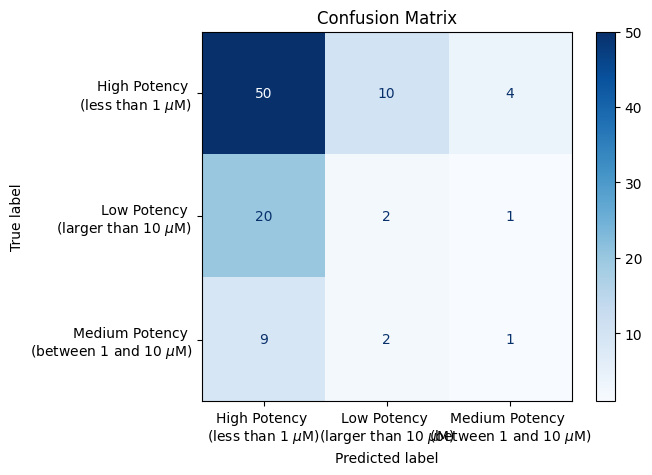

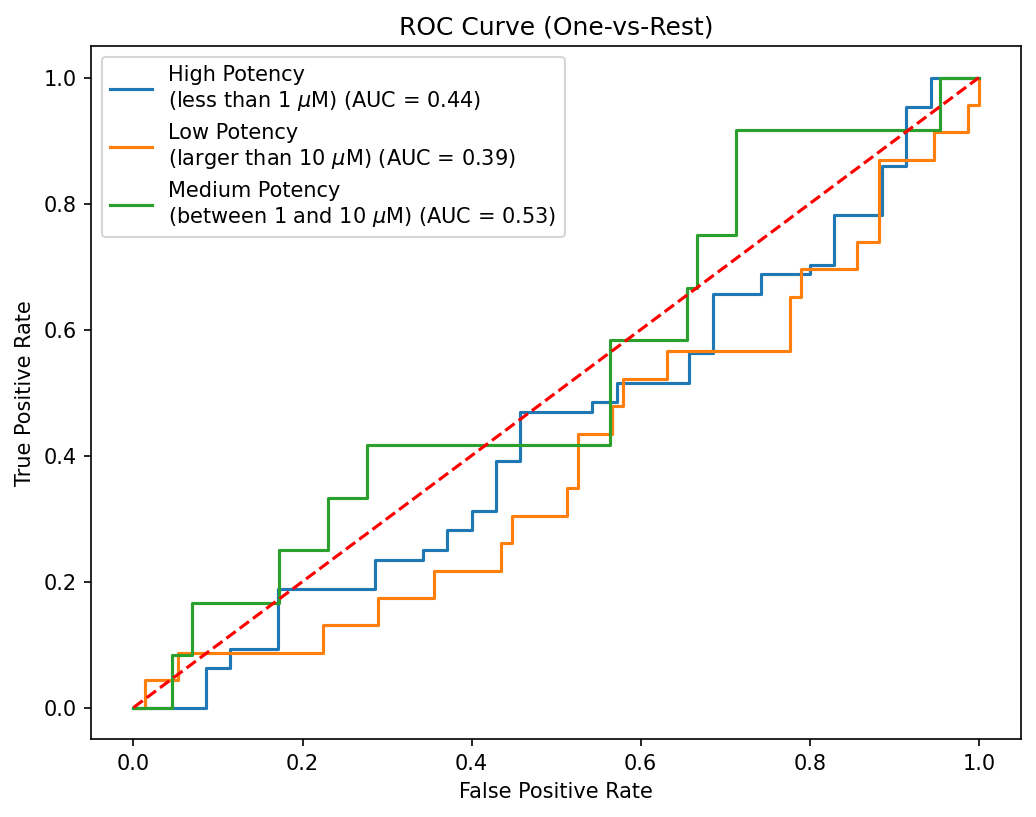

Evaluating the model...


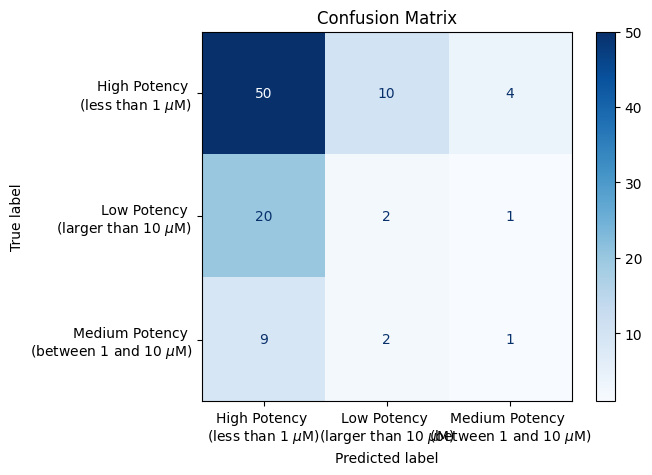

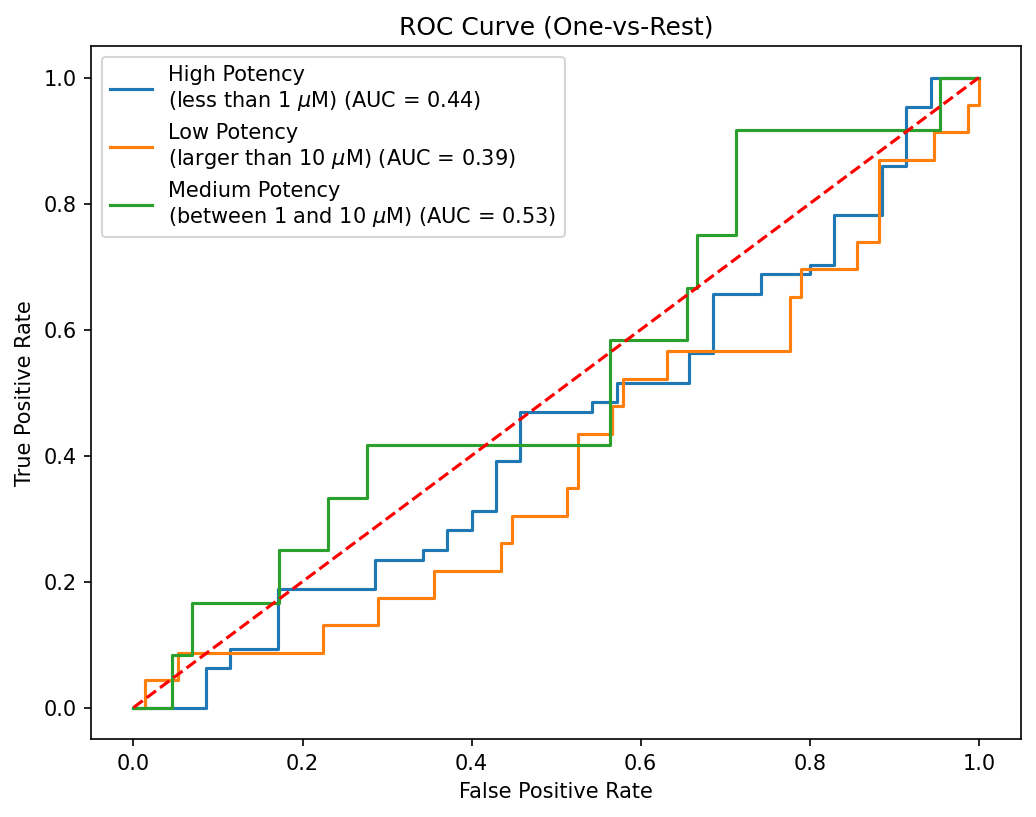

Training and evaluation complete
Training SVM model for classification using correlation_variance_filter features...
Running 5-fold cross-validation for SVM (classification)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 0.6667
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 0.5766
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 0.5946
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 0.5676
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 0.5495
Average Cross-Validation Metric: 0.5910
Test Accuracy: 0.4848


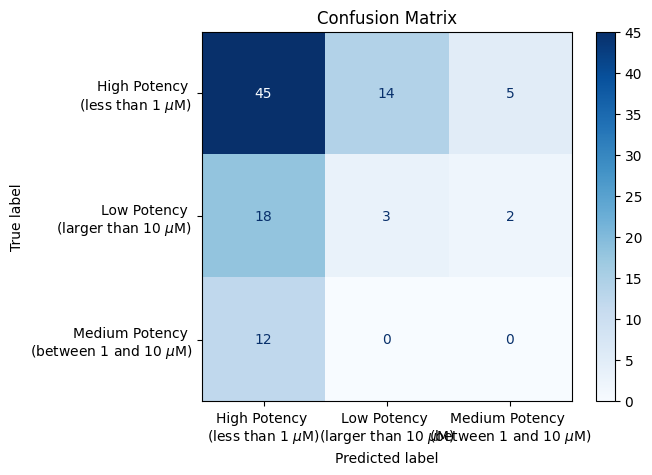

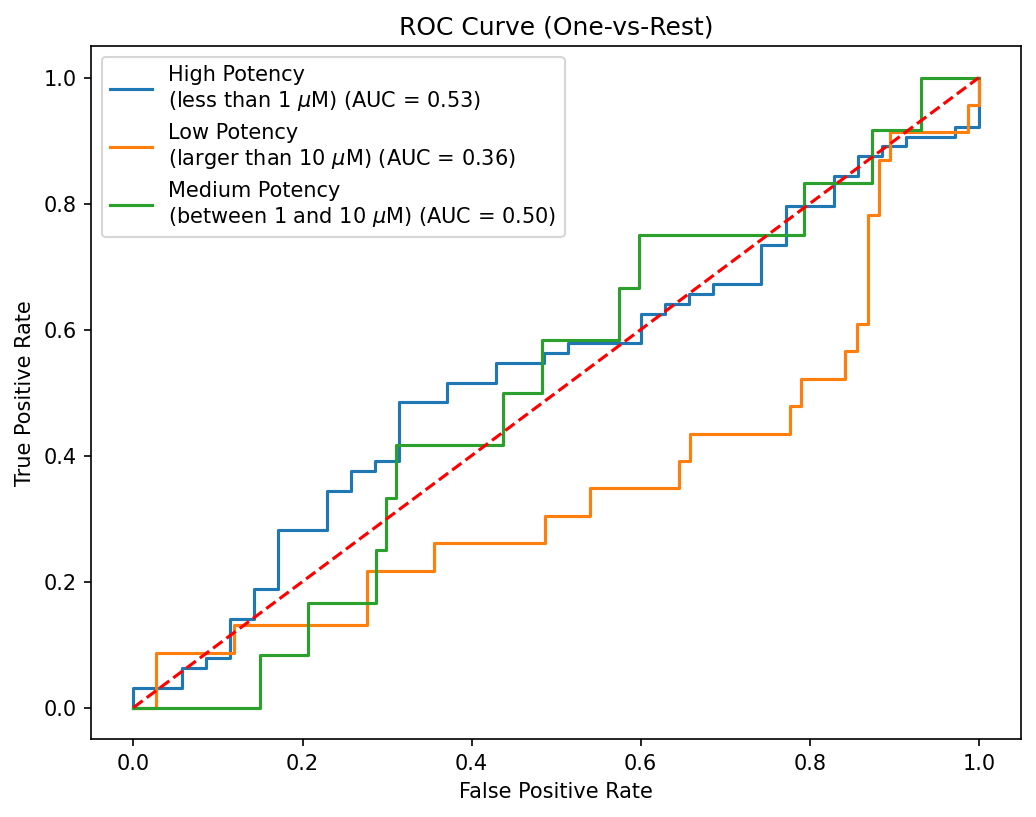

Evaluating the model...


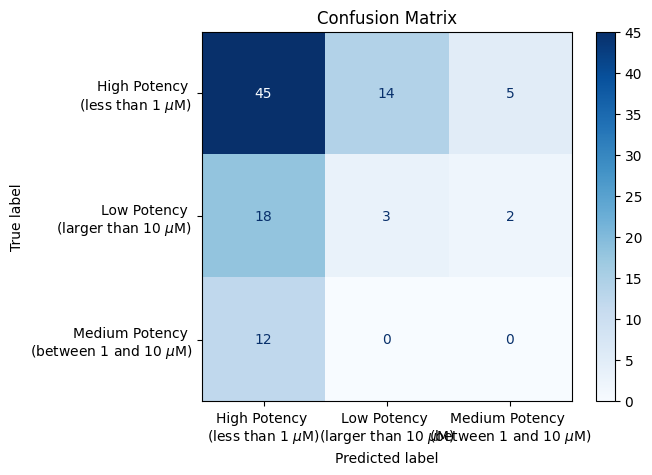

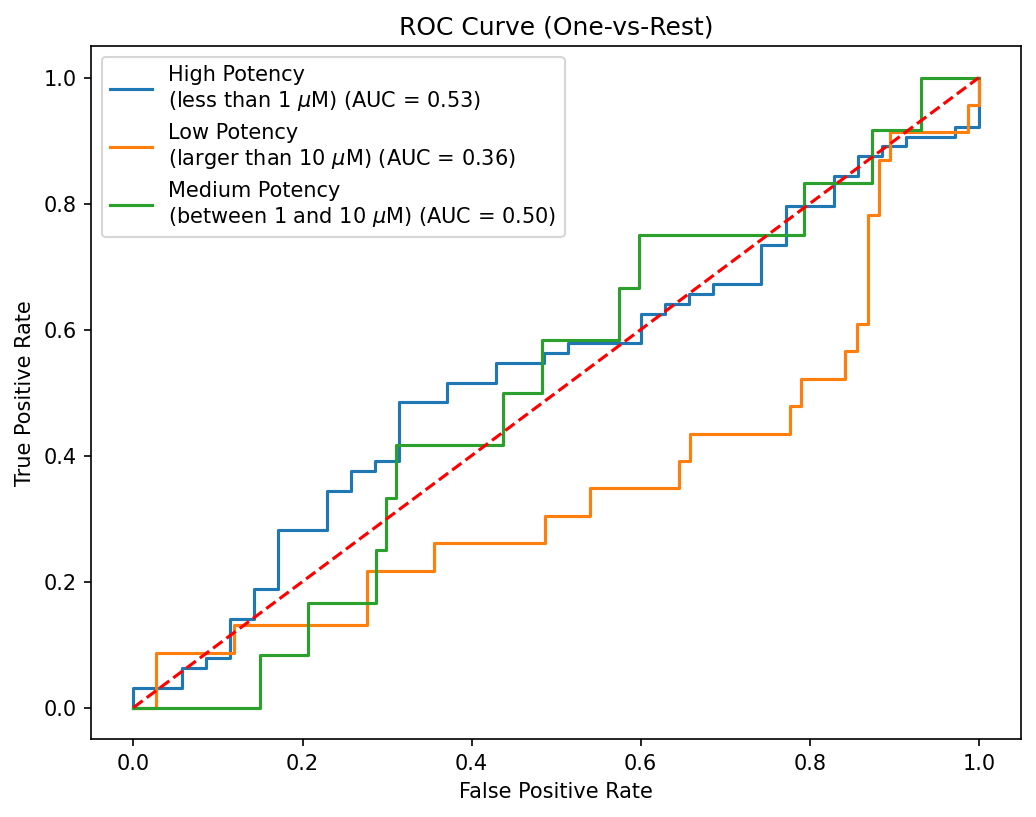

Training and evaluation complete
Training SVM model for classification using PCA features...
Running 5-fold cross-validation for SVM (classification)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 0.7027
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 0.6847
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 0.6306
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 0.6216
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 0.6126
Average Cross-Validation Metric: 0.6505
Test Accuracy: 0.6465


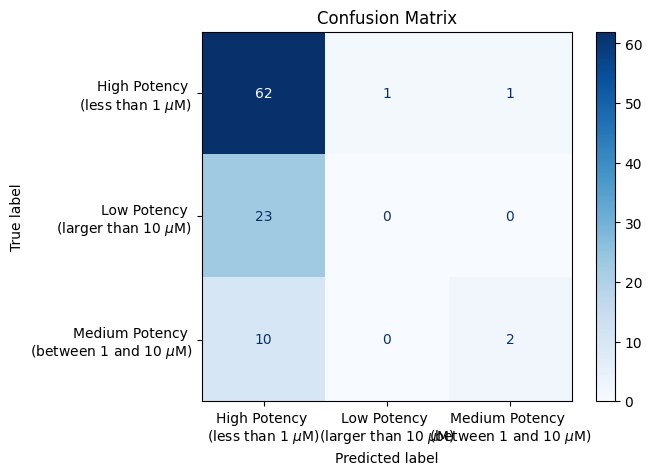

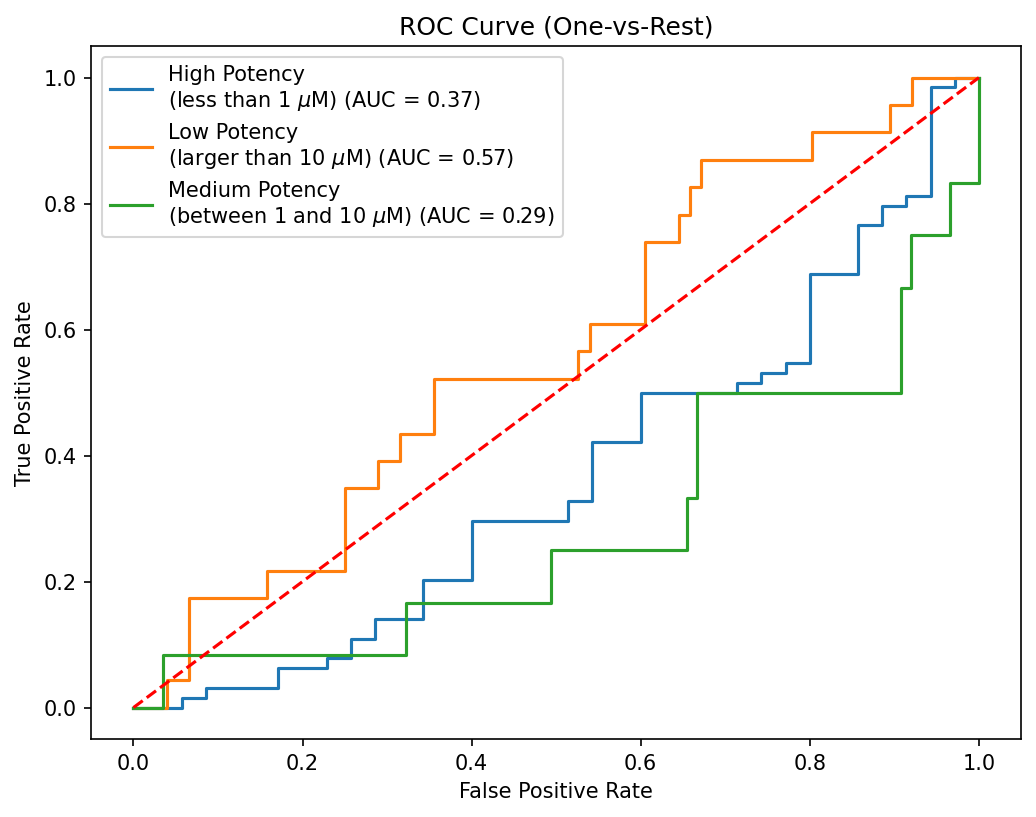

Evaluating the model...


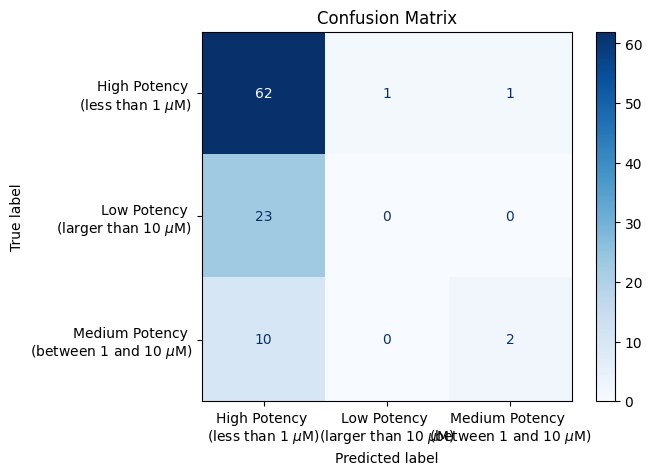

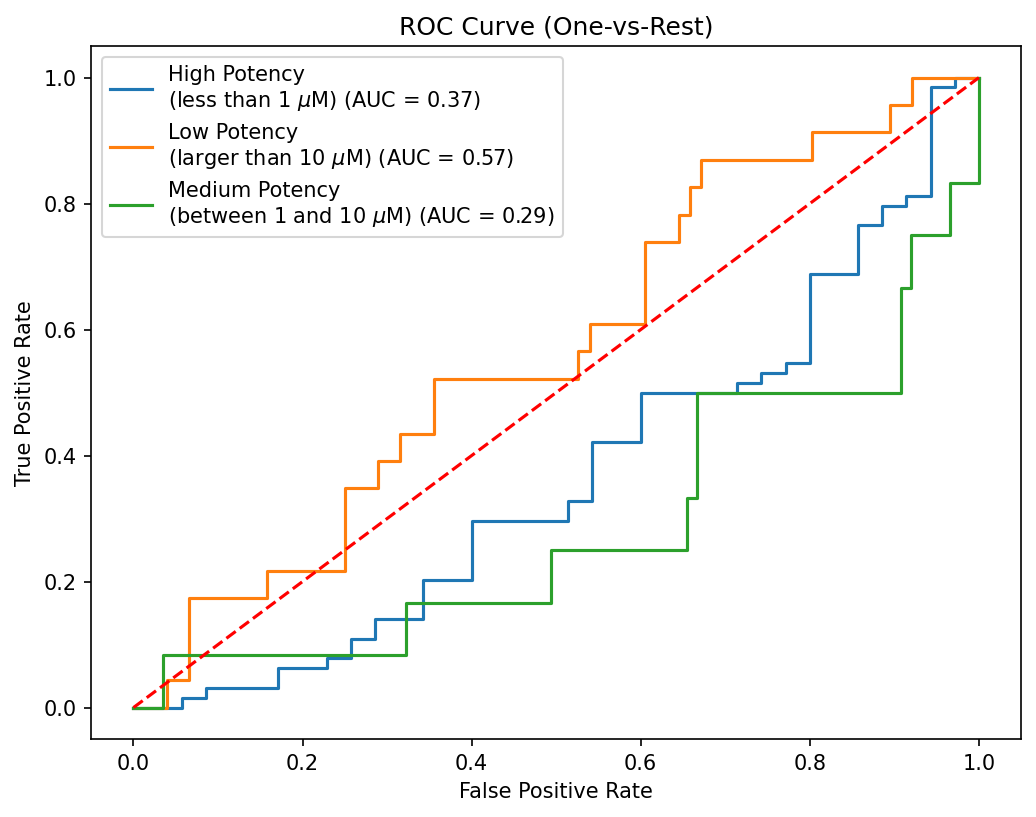

Training and evaluation complete
Training SVM model for classification using Factor_Analysis features...
Running 5-fold cross-validation for SVM (classification)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 0.4955
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 0.4595
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 0.5225
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 0.5315
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 0.4505
Average Cross-Validation Metric: 0.4919
Test Accuracy: 0.4545


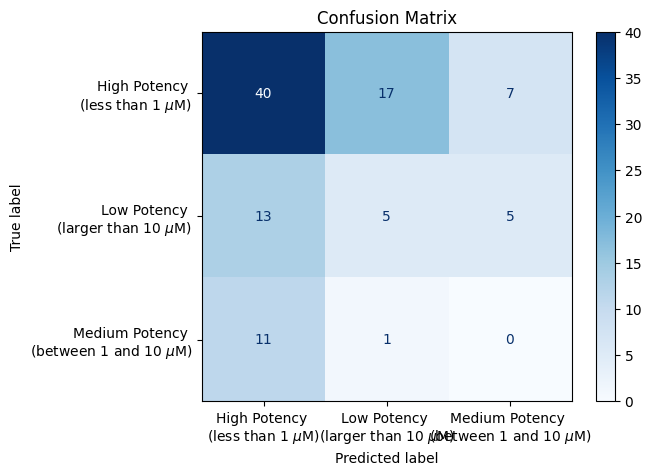

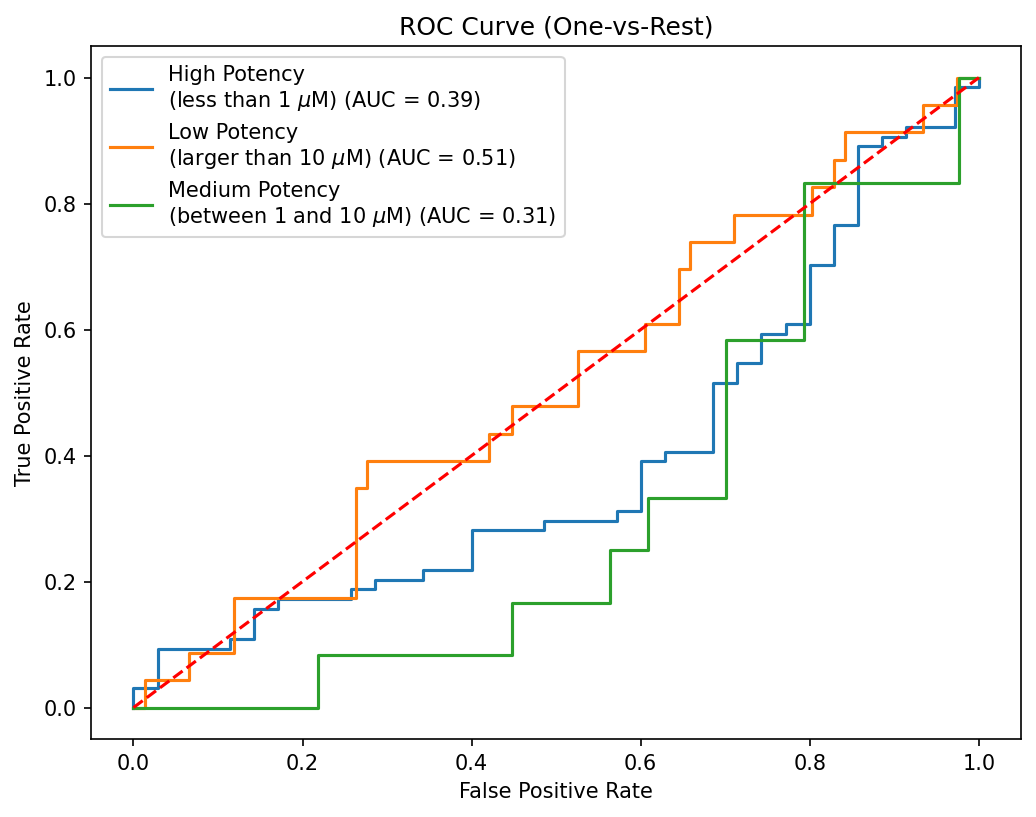

Evaluating the model...


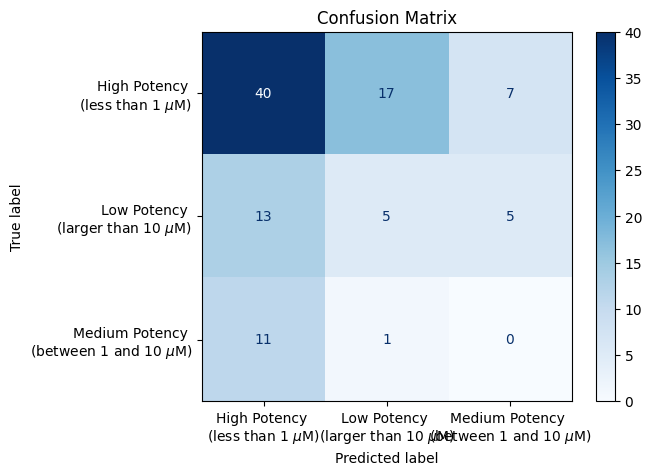

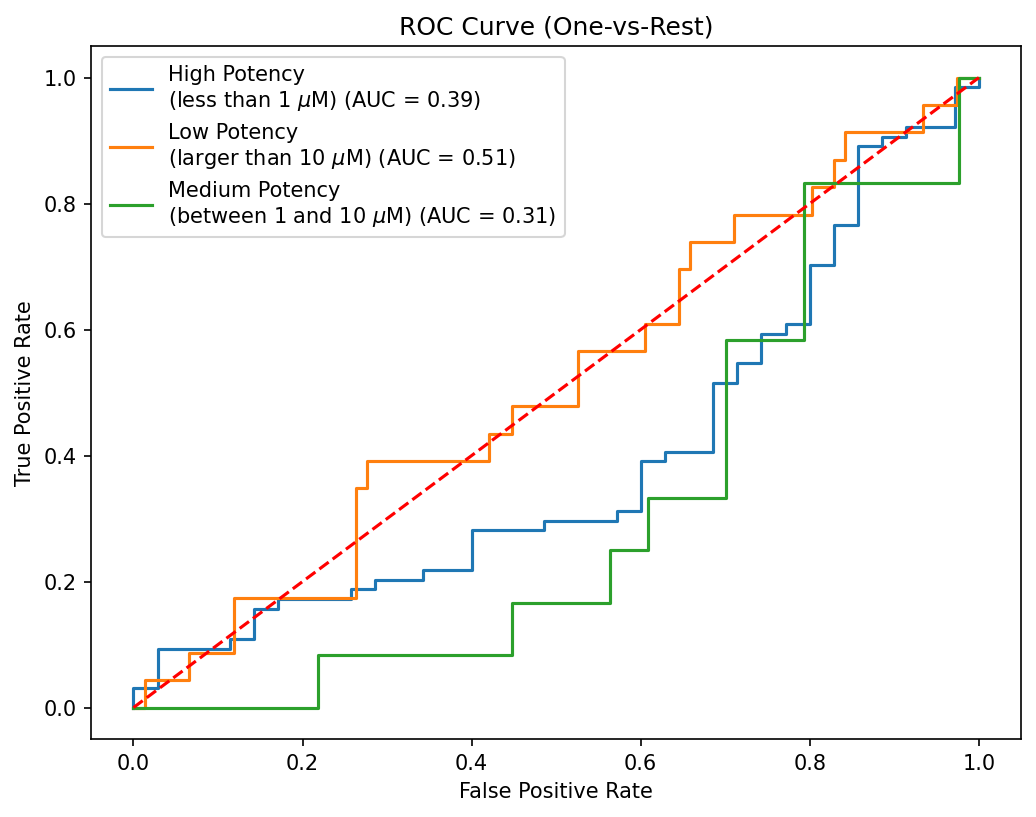

Training and evaluation complete


In [6]:
for problem_type in problem_types:
    for input_type in input_types:
        print(f"Training SVM model for {problem_type} using {input_type} features...")
        results = run_svm(problem_type=problem_type, input_type=input_type, seed=seed)
        
        # Unpack results
        final_model = results["best_model"]
        X_test = results["X_test"]
        y_test = results["y_test"]
        
        # Evaluate the model
        print(f"Evaluating the model...")
        evaluate_model(final_model, X_test, y_test, problem_type, input_type, "SVM")
        
        print("Training and evaluation complete")